In [37]:
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [38]:
from torchmetrics import MeanAbsolutePercentageError as MAPE

In [39]:
df = pd.read_csv("AirfoilSelfNoise.csv")
df.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [40]:
#Negative values check
df.lt(0).sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

In [41]:
#zeros check
(df == 0).sum()
#alpha being zero as it serves as angle of attack. 0 would equate to parallel flow

f               0
alpha         329
c               0
U_infinity      0
delta           0
SSPL            0
dtype: int64

In [42]:
#NAs check
df.isna().sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'U_infinity'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'SSPL'}>]], dtype=object)

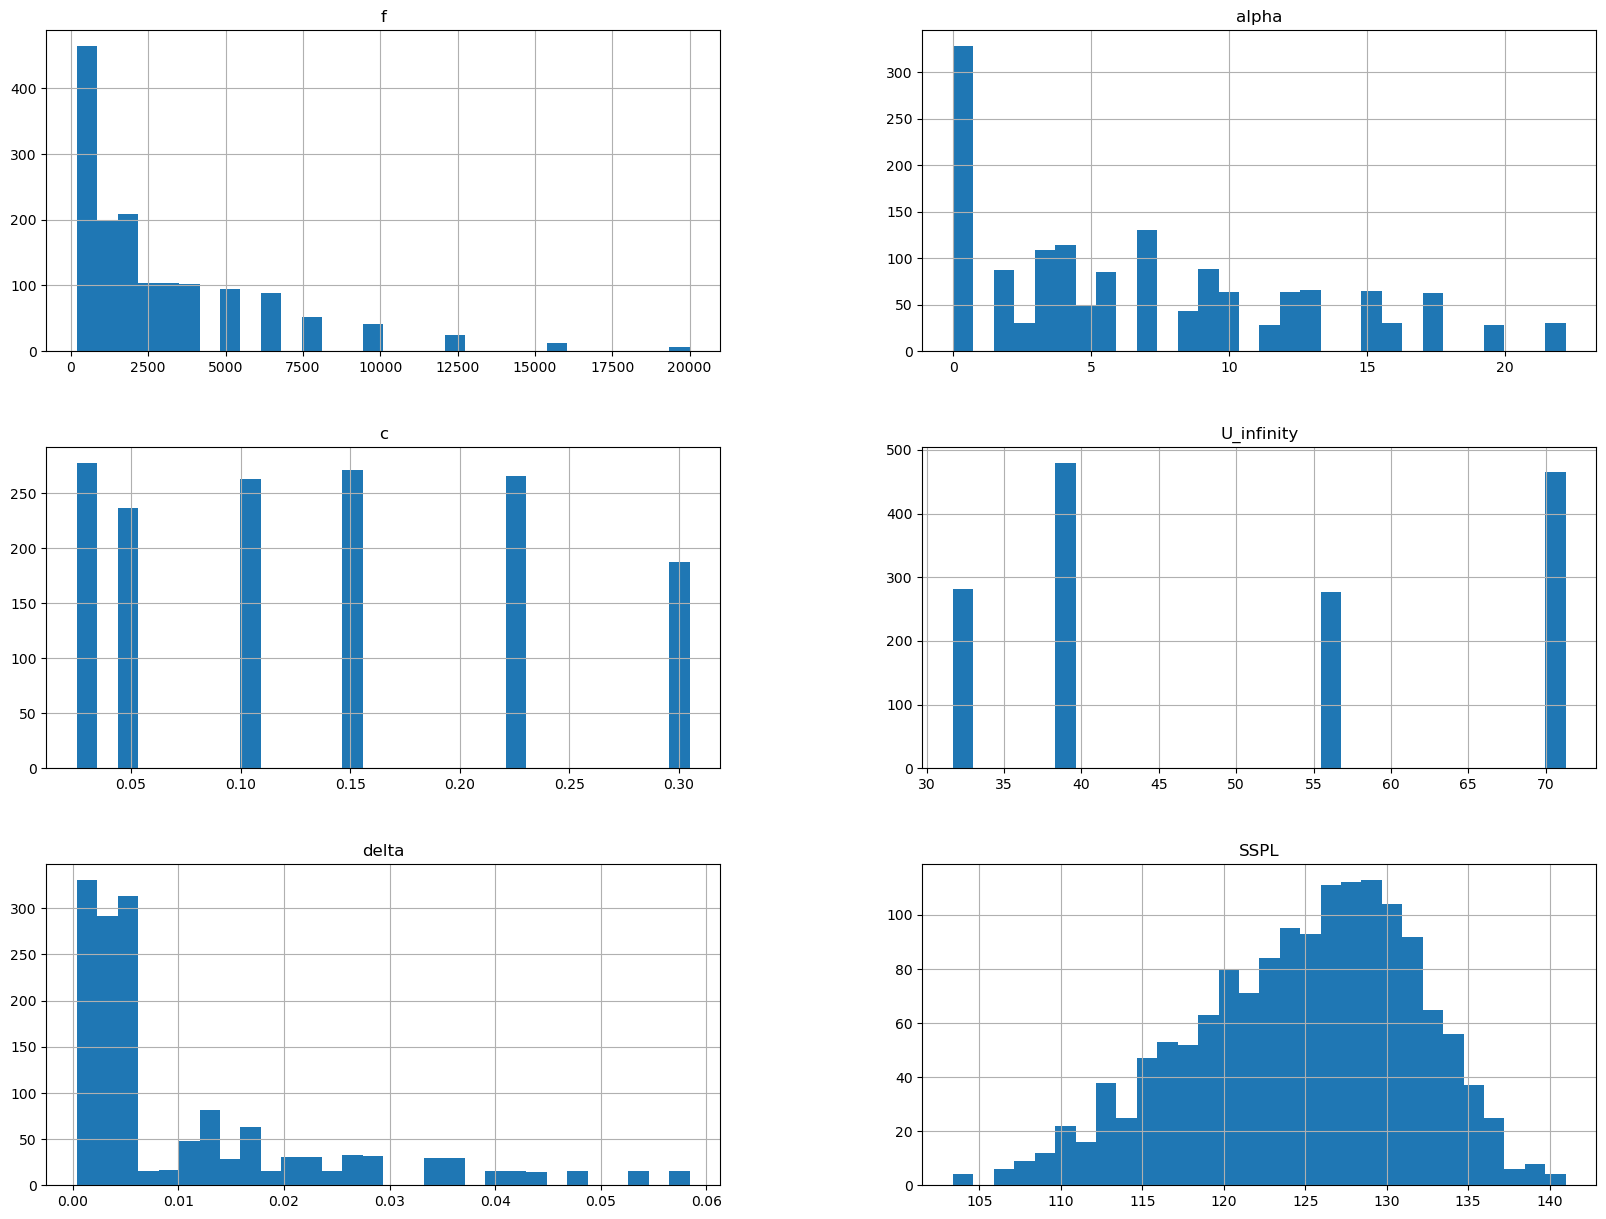

In [43]:
df.hist(bins=30, figsize=(20, 15))
#no majr outliers identified to perform any further clensing

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

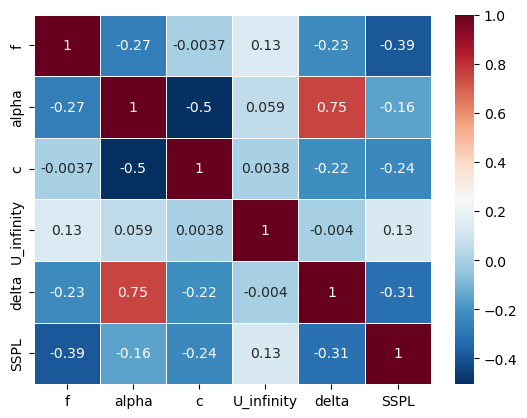

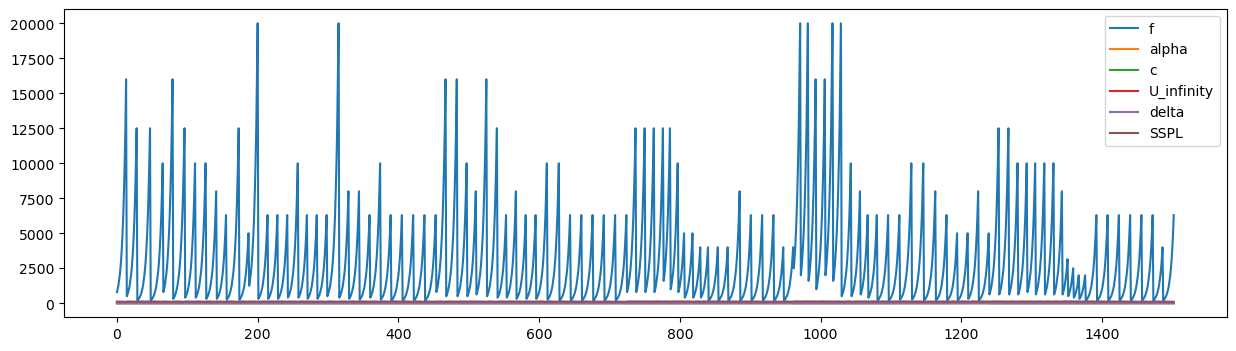

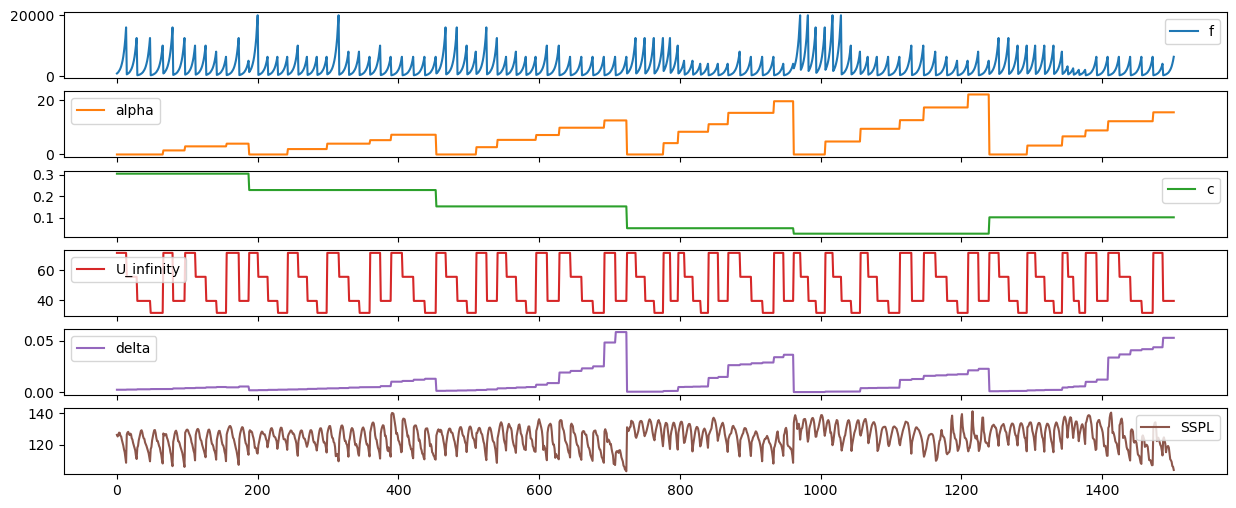

In [44]:
pearsoncorr = df.corr(method='pearson')
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

df.plot(figsize=(15,4))
df.plot(subplots=True, figsize=(15,6))

In [45]:
data = df.copy() # input data 
X = data.iloc[:,:5]
y = data.iloc[:,5]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [46]:
#scaling
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
#X_all = scaler.transform(X)

In [66]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
#x_all = torch.tensor(X_all,dtype=torch.float32)

c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
c:\Users\vborozniak\anaconda3\envs\gpu

In [ ]:
%reset

Epoch [1/50], Train Loss: 81.2445728077608, Val Loss: 25.70823860168457
Epoch [2/50], Train Loss: 20.36481262655819, Val Loss: 17.61624526977539
Epoch [3/50], Train Loss: 12.441458309397978, Val Loss: 9.300490379333496
Epoch [4/50], Train Loss: 7.819135862238267, Val Loss: 6.6723456382751465
Epoch [5/50], Train Loss: 6.672041668611414, Val Loss: 6.171664714813232
Epoch [6/50], Train Loss: 6.0647408541511085, Val Loss: 5.867103576660156
Epoch [7/50], Train Loss: 6.212157838484821, Val Loss: 6.682879447937012
Epoch [8/50], Train Loss: 6.56045529421638, Val Loss: 6.098728179931641
Epoch [9/50], Train Loss: 6.23738639494952, Val Loss: 6.027190208435059
Epoch [10/50], Train Loss: 6.204800802118638, Val Loss: 8.23888874053955
Epoch [11/50], Train Loss: 7.108973138472614, Val Loss: 5.980144500732422
Epoch [12/50], Train Loss: 5.835188501021442, Val Loss: 5.766439437866211
Epoch [13/50], Train Loss: 5.87557565464693, Val Loss: 6.567106246948242
Epoch [14/50], Train Loss: 6.133762527914608, Val

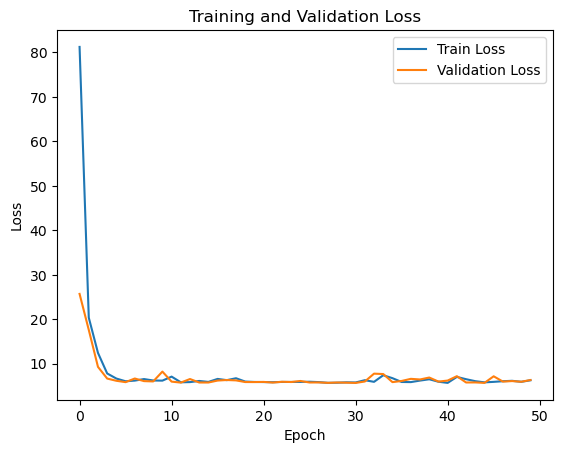

Feature Importance:
Input 1: 8.843886375427246
Input 2: 0.10118509829044342
Input 3: 8.336509704589844
Input 4: 0.0
Input 5: 8.074379920959473
Input 6: 0.0
Predicted: tensor([[122.8360],
        [121.2885],
        [130.1370],
        [120.3016],
        [124.3095],
        [132.3275],
        [126.6096],
        [130.8867],
        [123.8596],
        [125.8245],
        [124.4260],
        [128.1703],
        [131.7918],
        [129.3874],
        [131.9455],
        [127.0263],
        [130.6950],
        [127.3993],
        [127.5083],
        [123.1069],
        [124.2089],
        [126.5338],
        [123.0979],
        [123.1609],
        [122.7911],
        [121.7264],
        [122.9943],
        [128.8974],
        [128.2673],
        [124.1552],
        [122.6745],
        [126.9252],
        [120.8356],
        [124.2832],
        [129.8970],
        [130.2956],
        [122.9198],
        [123.2260],
        [125.0618],
        [124.2455],
        [126.1641],
        [125.

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# activation function - MAE
class MAEActivation(nn.Module):
    def __init__(self):
        super(MAEActivation, self).__init__()

    def forward(self, input):
        return input ** 2

        
        return x.float(), y.float()
# regression model -  5 input features, 1 output
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(5, 12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(12, 6)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.mae = MAEActivation()
        self.float()

    def forward(self, x):
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        return self.linear3(x)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create an instance of your regression model
model = RegressionModel()

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Train the model and collect loss history
num_epochs = 50
train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        val_loss = loss_fn(outputs, y_test)
        val_loss_history.append(val_loss.item())

    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss.item()}")

# Calculate feature importance using gradients
feature_importance = torch.abs(model.linear3.weight.grad).squeeze()

# Plot the history of loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print the feature importance
print("Feature Importance:")
for i, importance in enumerate(feature_importance):
    print(f"Input {i+1}: {importance.item()}")

# Test the trained model
predicted = model(X_test)
print("Predicted:", predicted)

# Calculate MAE between predicted and test values
mae = torch.mean(torch.abs(predicted - y_test))
print("MAE:", mae.item())


In [93]:
mape = torch.mean(torch.abs((y_test - predicted) / y_test)) * 100
print("MAPE:", mape.item(), "%")

MAPE: 5.1405558586120605 %


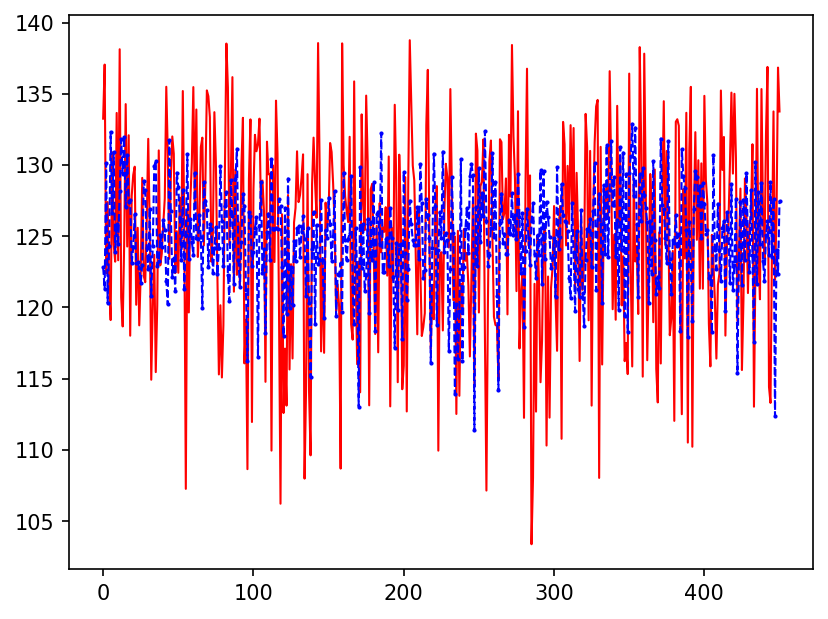

In [94]:
#%%Investigate
plt.figure(dpi=150)
plt.plot(y_test, color = 'red', label = 'Real',linewidth = 1)
plt.plot(predicted.detach().numpy(), color = 'blue', label = 'Predicted',linestyle = 'dashed',marker = 'o',markersize = 1,linewidth = 1)

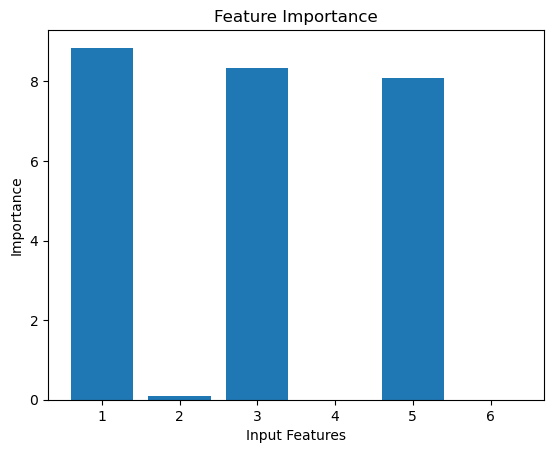

In [95]:
#add actual headers to axis
plt.bar(range(1, len(feature_importance) + 1), feature_importance)
plt.xlabel('Input Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
